In [4]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import argparse
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [5]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        if input_img.ndim == 3:
            img_h, img_w, img_c = input_img.shape
        elif input_img.ndim == 2:
            img_h, img_w = input_img.shape

        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            if input_img.ndim == 3:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            if input_img.ndim == 2:
                c = np.random.uniform(v_l, v_h, (h, w))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w] = c

        return input_img

    return eraser

In [6]:
base_path = "../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/"

In [7]:
batch_size=64
image_gen =  ImageDataGenerator(
        rescale = 1./255.,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))


train_flow= image_gen.flow_from_directory(
    base_path + 'train/',
    target_size = (224, 224),
    batch_size = batch_size,
    color_mode='grayscale',
    class_mode ='binary'
)
valid_flow = image_gen.flow_from_directory(
    base_path + 'valid/',
    target_size = (224, 224),
    batch_size = batch_size,
    color_mode='grayscale',
    class_mode = 'binary'
)
test_flow = image_gen.flow_from_directory(
    base_path + 'test/',
    target_size = (224, 224),
    batch_size = 1,
    shuffle = False,
    color_mode='grayscale',
    class_mode ='binary'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [8]:
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam

In [9]:
def build_model(pretrained):
    model = Sequential([
        pretrained,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )
    
    return mode

In [10]:
densenet = DenseNet121( weights=None, include_top=False, input_shape=(224,224,1) )
model = Sequential([ 
        densenet,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])

2022-01-28 07:41:41.419803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 07:41:41.540497: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 07:41:41.541709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 07:41:41.543450: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7031232   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 7,032,257
Trainable params: 6,948,609
Non-trainable params: 83,648
_________________________________________________________________


In [13]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer= opt, metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [14]:
from keras.callbacks import ModelCheckpoint
filepath = "saved-final-model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [16]:
train_steps = 100000//100
valid_steps = 20000//100

history = model.fit_generator(
    train_flow,
    epochs =15,
    callbacks= callbacks_list,
    steps_per_epoch = train_steps,
    validation_data = valid_flow,
    validation_steps = valid_steps
)

Epoch 1/15
1000/1000 [==============================] - 740s 740ms/step - loss: 0.4831 - accuracy: 0.7667 - val_loss: 0.6331 - val_accuracy: 0.6701

Epoch 00001: val_accuracy improved from 0.66094 to 0.67008, saving model to saved-final-model.h5
Epoch 2/15
1000/1000 [==============================] - 653s 653ms/step - loss: 0.4041 - accuracy: 0.8145 - val_loss: 0.4939 - val_accuracy: 0.7598

Epoch 00002: val_accuracy improved from 0.67008 to 0.75977, saving model to saved-final-model.h5
Epoch 3/15
1000/1000 [==============================] - 628s 628ms/step - loss: 0.3511 - accuracy: 0.8427 - val_loss: 0.5047 - val_accuracy: 0.7791

Epoch 00003: val_accuracy improved from 0.75977 to 0.77914, saving model to saved-final-model.h5
Epoch 4/15
1000/1000 [==============================] - 615s 614ms/step - loss: 0.3109 - accuracy: 0.8643 - val_loss: 0.9923 - val_accuracy: 0.6103

Epoch 00004: val_accuracy did not improve from 0.77914
Epoch 5/15
1000/1000 [==============================] - 61

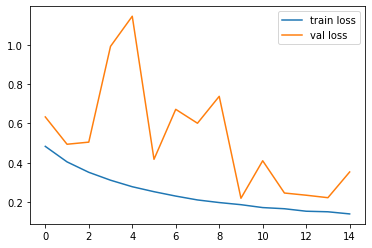

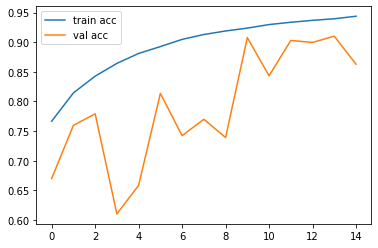

In [17]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [18]:
y_pred = model.predict(test_flow)
y_test = test_flow.classes

In [19]:
from sklearn import metrics

In [20]:
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))

ROC AUC Score: 0.9692447399999999
AP Score: 0.9688932232678242

              precision    recall  f1-score   support

           0       0.97      0.76      0.85     10000
           1       0.80      0.98      0.88     10000

    accuracy                           0.87     20000
   macro avg       0.88      0.87      0.86     20000
weighted avg       0.88      0.87      0.86     20000



In [21]:
y_test1 = np.array(y_test)
y_test1

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [22]:
y_pred1 = y_pred.copy()
np.where(y_pred1 > 0.5, 1, 0)

array([[1],
       [0],
       [1],
       ...,
       [0],
       [1],
       [1]])

In [23]:
y_pred2 = y_pred1.flatten()
y_pred2 = np.where(y_pred2 > 0.5, 1, 0)
y_pred2

array([1, 0, 1, ..., 0, 1, 1])

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred2)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[7557 2443]
 [ 238 9762]]
acc: 0.8659
sensitivity: 0.7557
specificity: 0.9762


<AxesSubplot:>

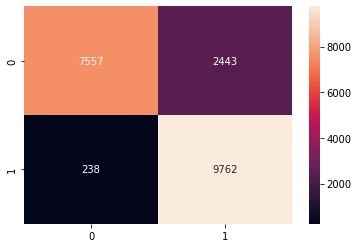

In [25]:
import seaborn as sns
sns.heatmap(cm,annot=True, fmt='g')

In [1]:
train_flow.class_indices

NameError: name 'train_flow' is not defined